In [ ]:
from google.colab import files

# Upload kaggle.json
files.upload()

{}

In [ ]:
import os

# Create Kaggle folder and move the file
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Set permission


In [ ]:
!kaggle datasets download -d misrakahmed/vegetable-image-dataset

Dataset URL: https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset
License(s): CC-BY-SA-4.0
 97% 517M/534M [00:03<00:00, 161MB/s]
100% 534M/534M [00:03<00:00, 160MB/s]


In [ ]:
import zipfile

with zipfile.ZipFile("vegetable-image-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("vegetable_dataset")

print("\n✅ Dataset Downloaded & Extracted Successfully!")



✅ Dataset Downloaded & Extracted Successfully!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil

In [ ]:
shutil.rmtree("vegetable_dataset/selected_vegetables",ignore_errors=True)


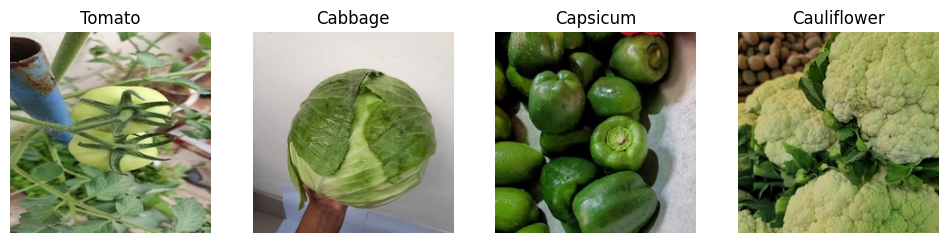

In [ ]:
dataset_path = "vegetable_dataset/Vegetable Images/train"

# รายการผักที่ต้องการใช้สำหรับเทรน (เลือกเฉพาะพืชที่แตกต่างกันชัดเจน)
selected_classes = [ "Tomato", "Cabbage", "Capsicum", "Cauliflower"]

# กำหนดโฟลเดอร์สำหรับเก็บข้อมูลที่คัดเลือกแล้ว
selected_train_path = "vegetable_dataset/selected_vegetables/train"
if not os.path.exists(selected_train_path):
  os.makedirs(selected_train_path, exist_ok=True)

  # คัดลอกเฉพาะโฟลเดอร์ที่ต้องการ
  for class_name in selected_classes:
      src = os.path.join(dataset_path, class_name)
      dst = os.path.join(selected_train_path, class_name)
      shutil.copytree(src, dst)

def plot_images(selected_classes):

    # Create a figure
    plt.figure(figsize=(12, 12))
    for i, cat in enumerate(selected_classes):

        # Load images for the ith category
        image_path = selected_train_path + '/' + cat
        images_in_folder = os.listdir(image_path)
        first_image_of_folder = images_in_folder[0]
        first_image_path = image_path + '/' + first_image_of_folder
        img = image.load_img(first_image_path)
        img_arr = image.img_to_array(img)/255.0


        # Create Subplot and plot the images
        plt.subplot(4, 4, i+1)
        plt.imshow(img_arr)
        plt.title(cat)
        plt.axis('off')

    plt.show()

# Call the function
plot_images(selected_classes)

In [ ]:
import os
from PIL import Image

dataset_path = "vegetable_dataset/Vegetable Images/train"

# ตรวจสอบไฟล์ภาพที่เสียหาย
for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    if os.path.isdir(category_path):
        for img_file in os.listdir(category_path):
            img_path = os.path.join(category_path, img_file)
            try:
                img = Image.open(img_path)  # ลองเปิดไฟล์
                img.verify()  # ตรวจสอบว่าเป็นภาพจริงหรือไม่
            except (IOError, SyntaxError):
                print(f"❌ Corrupted image found: {img_path}")


In [ ]:
# Normalization และ Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# โหลดข้อมูลสำหรับ Train และ Validation
train_generator = train_datagen.flow_from_directory(
    selected_train_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    selected_train_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 3200 images belonging to 4 classes.
Found 800 images belonging to 4 classes.


In [ ]:
# Build a custom sequential CNN model
num_classes = len(train_generator.class_indices)

model = Sequential() # model object

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(48, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')  # ✅ ตรงกับจำนวนคลาส
])


# Compile โมเดล

# print the model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 82944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 48)                  │       3,981,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             196 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,000,948 (15.26 MB)

 Trainable params: 4,000,948 (15.26 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=12,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
  4/100 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.2988 - loss: 2.5454

KeyboardInterrupt: 

In [ ]:
def plot_training_history(history):
    # Create a figure
    plt.figure(figsize=(12, 5))

    # 🔹 Plot Training & Validation Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Model Accuracy")

    # 🔹 Plot Training & Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Model Loss")

    # Show the plots
    plt.show()

# 🔹 Call the function after training the model
plot_training_history(history)

NameError: name 'history' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step


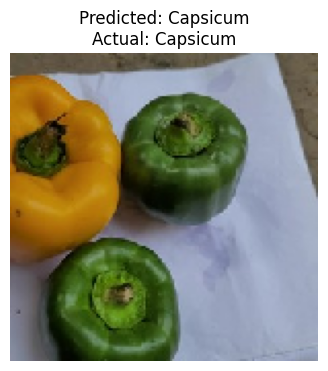

🔹 Image File: 0686.jpg (Capsicum)


In [ ]:
import random
import os

# 🔹 Mapping Class Indices to Class Names
class_map = dict([(v, k) for k, v in train_generator.class_indices.items()])

# 🔹 Function to Randomly Select an Image and Predict its Class
def generate_random_prediction(test_data_path):
    random_class = random.choice(os.listdir(test_data_path))
    class_path = os.path.join(test_data_path, random_class)

    random_image_name = random.choice(os.listdir(class_path))
    random_image_path = os.path.join(class_path, random_image_name)

    test_img = image.load_img(random_image_path, target_size=(150, 150))
    test_img_arr = image.img_to_array(test_img) / 255.0
    test_img_input = np.expand_dims(test_img_arr, axis=0)  # Reshape for model input

    predicted_label = np.argmax(model.predict(test_img_input))
    predicted_vegetable = class_map[predicted_label]

    plt.figure(figsize=(4, 4))
    plt.imshow(test_img_arr)
    plt.title(f"Predicted: {predicted_vegetable}\nActual: {random_class}")
    plt.axis('off')
    plt.show()

    print(f"🔹 Image File: {random_image_name} ({random_class})")

# Call the function with test dataset path
generate_random_prediction(selected_train_path)


In [ ]:
model.save("vegetable_cnn_model.h5")